In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection
from scipy.signal import butter,filtfilt,iirnotch,hilbert
from PyEMD import EMD
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import h5py

In [14]:
wLen = 250 #ms
stepLen = 50 #ms
freq = 4000 #Hz

def filter (emg):
    b, a = butter(N=1, Wn=120.0, btype='highpass', analog=False, fs=4000.0)
    # what axis should the filter apply to? other datasets have axis=0
    return torch.from_numpy(np.flip(filtfilt(b, a, emg),axis=-1).copy())

numGestures = []

def getData(file, gesture):
    global numGestures
    data = filter(torch.from_numpy(np.array(file[gesture])).unfold(dimension=-1, size=int(wLen/1000*freq), step=int(stepLen/1000*freq)))
    if (len(data) == 10):
        numGestures += [10]
        return torch.cat((data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9]), axis=1).permute([1, 0, 2])
    elif (len(data) == 9):
        numGestures += [9]
        return torch.cat((data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8]), axis=1).permute([1, 0, 2])
    else:
        numGestures += [8]
        return torch.cat((data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7]), axis=1).permute([1, 0, 2])

def getEMG(n):
    if (n<10):
        f = h5py.File('./Jehan_Dataset/p00' + str(n) +'/data_allchannels_initial.h5', 'r')
    else:
        f = h5py.File('./Jehan_Dataset/p0' + str(n) +'/data_allchannels_initial.h5', 'r')
    #print(f.keys())
    return torch.cat((getData(f, 'abduct_p1'), getData(f, 'adduct_p1'), getData(f, 'extend_p1'), getData(f, 'grip_p1'), getData(f, 'pronate_p1'),
                      getData(f, 'rest_p1'), getData(f, 'supinate_p1'), getData(f, 'tripod_p1'), getData(f, 'wextend_p1'), getData(f, 'wflex_p1')), axis=0)

def makeLabels (length, num):
    labels = torch.tensor(())
    labels = labels.new_zeros(size=(length, 10))
    for i in range (len(labels)):
        labels[i][num] = 1.0
    return labels

'''
emg_9 = getEMG(9)
emg_11 = getEMG(11)
emg_12 = getEMG(12) 
'''
subject = 22
emg = getEMG(subject)
print(emg.size())

labels = torch.tensor(()).new_zeros(size=(len(emg), 10))
windowsPerSample = 36
numGestures = [(i * windowsPerSample) for i in numGestures]
print(numGestures)

index = 0
count = 0
for i in range(len(labels)):
    labels[i][index] = 1.0
    count += 1
    if (count >= numGestures[index]):
        index += 1
        count = 0
print(labels.size())

torch.Size([3492, 64, 1000])
[360, 360, 360, 324, 360, 324, 360, 324, 360, 360]
torch.Size([3492, 10])


In [1]:
cmap = mpl.colormaps['jet']

def getImages (emg):
    allImages = []
    for i in range (len(emg)):
    #for i in range (5):
        #data = np.abs(emg[i].numpy())/50.0
        #data = np.log10(np.abs(emg[i].numpy()))/2.5
        data = np.log(np.abs(emg[i].numpy()))/5.0
        #data = np.log2(np.log2(((np.abs(emg[i].numpy()))*10.0)+1))/5.5
        image = np.zeros((3, len(data), len(data[0])))
        #image = np.array([(np.array([(cmap(x)) for x in col])) for col in data], dtype='float32')[:3]
        image = np.transpose(np.array(list(map(lambda col: np.array(list(map(lambda x: (cmap(x)), col))), data))), axes=[2, 0, 1])[:3]
        '''
        for p in range (len(data)):
            for q in range (len(data[p])):
                image[:, p, q] = cmap(data[p][q])[:3]
        '''

        image = transforms.Resize([224, 224], interpolation=transforms.InterpolationMode.BICUBIC, antialias=True)(torch.from_numpy(image))
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        #image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(torch.from_numpy(image))
        allImages.append(image.numpy().astype(np.float32))

        if i % 100 == 0:
            print("progress: " + str(i) + "/" + str(len(emg)))
            print(labels[i])
            plt.imshow(allImages[i].T, origin='lower')
            plt.axis('off')
            plt.show()
            
    return allImages

#for a in range (10):
file_path = "./Jehan_Dataset/rawImages_" + str(subject) + ".npy"
data = getImages(emg)
#np.save(file_path, data)
file_path = "./Jehan_Dataset/labels_" + str(subject) + ".npy"
#np.save(file_path, labels)

NameError: name 'mpl' is not defined

In [2]:
leaveOut = False

labels_8 = np.load("./Jehan_Dataset/labels_8.npy").astype(np.float16)
labels_13 = np.load("./Jehan_Dataset/labels_13.npy").astype(np.float16)
labels_18 = np.load("./Jehan_Dataset/labels_18.npy").astype(np.float16)
labels_20 = np.load("./Jehan_Dataset/labels_20.npy").astype(np.float16)
labels_21 = np.load("./Jehan_Dataset/labels_21.npy").astype(np.float16)
labels_22 = np.load("./Jehan_Dataset/labels_22.npy").astype(np.float16)
otherLabels = np.load("./Jehan_Dataset/labels.npy").astype(np.float16)
'''
emg_8 = np.load("./Jehan_Dataset/rawImages_8.npy").astype(np.float16)
emg_9 = np.load("./Jehan_Dataset/rawImages_9.npy").astype(np.float16)
emg_11 = np.load("./Jehan_Dataset/rawImages_11.npy").astype(np.float16)
emg_12 = np.load("./Jehan_Dataset/rawImages_12.npy").astype(np.float16)
emg_13 = np.load("./Jehan_Dataset/rawImages_13.npy").astype(np.float16)
emg_15 = np.load("./Jehan_Dataset/rawImages_15.npy").astype(np.float16)
emg_16 = np.load("./Jehan_Dataset/rawImages_16.npy").astype(np.float16)
emg_17 = np.load("./Jehan_Dataset/rawImages_17.npy").astype(np.float16)
emg_18 = np.load("./Jehan_Dataset/rawImages_18.npy").astype(np.float16)
emg_19 = np.load("./Jehan_Dataset/rawImages_19.npy").astype(np.float16)
#emg_20 = np.load("./Jehan_Dataset/rawImages_20.npy").astype(np.float16)
#emg_21 = np.load("./Jehan_Dataset/rawImages_21.npy").astype(np.float16)
#emg_22 = np.load("./Jehan_Dataset/rawImages_22.npy").astype(np.float16)
'''
#data = np.concatenate((emg_8, emg_9, emg_11, emg_12, emg_13, emg_15, emg_16, emg_17, emg_18, emg_19, emg_20, emg_21, emg_22), axis=0, dtype=np.float16)
'''
data = np.concatenate((np.load("./Jehan_Dataset/rawImages_8.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_9.npy").astype(np.float16), 
                       np.load("./Jehan_Dataset/rawImages_11.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_12.npy").astype(np.float16),
                        np.load("./Jehan_Dataset/rawImages_13.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_15.npy").astype(np.float16),
                        np.load("./Jehan_Dataset/rawImages_16.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_17.npy").astype(np.float16),
                        np.load("./Jehan_Dataset/rawImages_18.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_19.npy").astype(np.float16)), axis=0, dtype=np.float16)
'''
combined_labels = np.concatenate((labels_8, otherLabels, otherLabels, otherLabels, labels_13, otherLabels, otherLabels, otherLabels, labels_18,
                                  otherLabels), axis=0, dtype=np.float16)

if leaveOut:
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(data, combined_labels, test_size=0.1)
    X_test = outEMG
    Y_test = outLabels
else:
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(np.concatenate((np.load("./Jehan_Dataset/rawImages_8.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_9.npy").astype(np.float16), 
                       np.load("./Jehan_Dataset/rawImages_11.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_12.npy").astype(np.float16),
                        np.load("./Jehan_Dataset/rawImages_13.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_15.npy").astype(np.float16),
                        np.load("./Jehan_Dataset/rawImages_16.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_17.npy").astype(np.float16),
                        np.load("./Jehan_Dataset/rawImages_18.npy").astype(np.float16), np.load("./Jehan_Dataset/rawImages_19.npy").astype(np.float16)), axis=0, dtype=np.float16), combined_labels, test_size=0.2)
    X_validation, X_test, Y_validation, Y_test = model_selection.train_test_split(X_validation, Y_validation, test_size=0.5)

X_train = torch.from_numpy(X_train).to(torch.float32)
Y_train = torch.from_numpy(Y_train).to(torch.float32)
X_validation = torch.from_numpy(X_validation).to(torch.float32)
Y_validation = torch.from_numpy(Y_validation).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(Y_test).to(torch.float32)
print(X_train.size())
print(X_validation.size())
print(X_test.size())

torch.Size([28540, 3, 224, 224])
torch.Size([3568, 3, 224, 224])
torch.Size([3568, 3, 224, 224])


: 

In [11]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-2])
#model = nn.Sequential(*list(model.children())[:-4])
num_features = model[-1][-1].conv3.out_channels
#num_features = model.fc.in_features
dropout = 0.5

num = 0
for name, param in model.named_parameters():
    num += 1
    if (num > 159): # for freezing layers 1, 2, 3, and 4
    #if (num > 129): # for freezing layers 1, 2, and 3
    #if (num > 72): # for freezing layers 1 and 2
    #if (num > 33): #for freezing layer 1
    #if (num >= 0): # for no freezing
        param.requires_grad = True
    else:
        param.requires_grad = False

model.add_module('avgpool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(num_features, 512))
model.add_module('relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(dropout))
model.add_module('fc2', nn.Linear(512, 512))
model.add_module('relu2', nn.ReLU())
model.add_module('dropout2', nn.Dropout(dropout))
model.add_module('fc3', nn.Linear(512, 10))
model.add_module('softmax', nn.Softmax(dim=1))

layers = [(name, param.requires_grad) for name, param in model.named_parameters()]
for i in range(len(layers)):
    print(layers[i])

('0.weight', False)
('1.weight', False)
('1.bias', False)
('4.0.conv1.weight', False)
('4.0.bn1.weight', False)
('4.0.bn1.bias', False)
('4.0.conv2.weight', False)
('4.0.bn2.weight', False)
('4.0.bn2.bias', False)
('4.0.conv3.weight', False)
('4.0.bn3.weight', False)
('4.0.bn3.bias', False)
('4.0.downsample.0.weight', False)
('4.0.downsample.1.weight', False)
('4.0.downsample.1.bias', False)
('4.1.conv1.weight', False)
('4.1.bn1.weight', False)
('4.1.bn1.bias', False)
('4.1.conv2.weight', False)
('4.1.bn2.weight', False)
('4.1.bn2.bias', False)
('4.1.conv3.weight', False)
('4.1.bn3.weight', False)
('4.1.bn3.bias', False)
('4.2.conv1.weight', False)
('4.2.bn1.weight', False)
('4.2.bn1.bias', False)
('4.2.conv2.weight', False)
('4.2.bn2.weight', False)
('4.2.bn2.bias', False)
('4.2.conv3.weight', False)
('4.2.bn3.weight', False)
('4.2.bn3.bias', False)
('5.0.conv1.weight', False)
('5.0.bn1.weight', False)
('5.0.bn1.bias', False)
('5.0.conv2.weight', False)
('5.0.bn2.weight', False)
('5.0

In [112]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-2])
#model = nn.Sequential(*list(model.children())[:-4])
num_features = model[-1][-1].conv3.out_channels
#num_features = model.fc.in_features
dropout = 0.5
model.add_module('avgpool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(num_features, 512))
model.add_module('relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(dropout))
model.add_module('fc2', nn.Linear(512, 512))
model.add_module('relu2', nn.ReLU())
model.add_module('dropout2', nn.Dropout(dropout))
model.add_module('fc3', nn.Linear(512, 10))
model.add_module('softmax', nn.Softmax(dim=1))

num = 0
for name, param in model.named_parameters():
    num += 1
    #if (num > 72):
    if (num > 33): #for -4
    #if (num >= 0):
        param.requires_grad = True
    else:
        param.requires_grad = False

#layers = [(name, param.requires_grad) for name, param in model.named_parameters()]
#for i in range(len(layers)):
    #print(layers[i])

class Data(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

batch_size = 32
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_validation, Y_validation)), batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
learn = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learn)

cuda
Epoch 1/10 | Train Loss: 2.2003 | Val Loss: 2.0117
Train Accuracy: 0.3059 | Val Accuracy: 0.5443
Epoch 2/10 | Train Loss: 1.9092 | Val Loss: 1.6909
Train Accuracy: 0.5722 | Val Accuracy: 0.7917
Epoch 3/10 | Train Loss: 1.6016 | Val Loss: 1.4972
Train Accuracy: 0.8847 | Val Accuracy: 0.9688
Epoch 4/10 | Train Loss: 1.5049 | Val Loss: 1.4809
Train Accuracy: 0.9632 | Val Accuracy: 0.9792
Epoch 5/10 | Train Loss: 1.4953 | Val Loss: 1.4742
Train Accuracy: 0.9691 | Val Accuracy: 0.9870
Epoch 6/10 | Train Loss: 1.4904 | Val Loss: 1.4685
Train Accuracy: 0.9736 | Val Accuracy: 0.9948
Epoch 7/10 | Train Loss: 1.4817 | Val Loss: 1.4682
Train Accuracy: 0.9819 | Val Accuracy: 0.9922
Epoch 8/10 | Train Loss: 1.4765 | Val Loss: 1.4664
Train Accuracy: 0.9858 | Val Accuracy: 0.9948
Epoch 9/10 | Train Loss: 1.4793 | Val Loss: 1.4632
Train Accuracy: 0.9833 | Val Accuracy: 1.0000
Epoch 10/10 | Train Loss: 1.4727 | Val Loss: 1.4638
Train Accuracy: 0.9899 | Val Accuracy: 0.9974
Test Loss: 1.4816 | Test

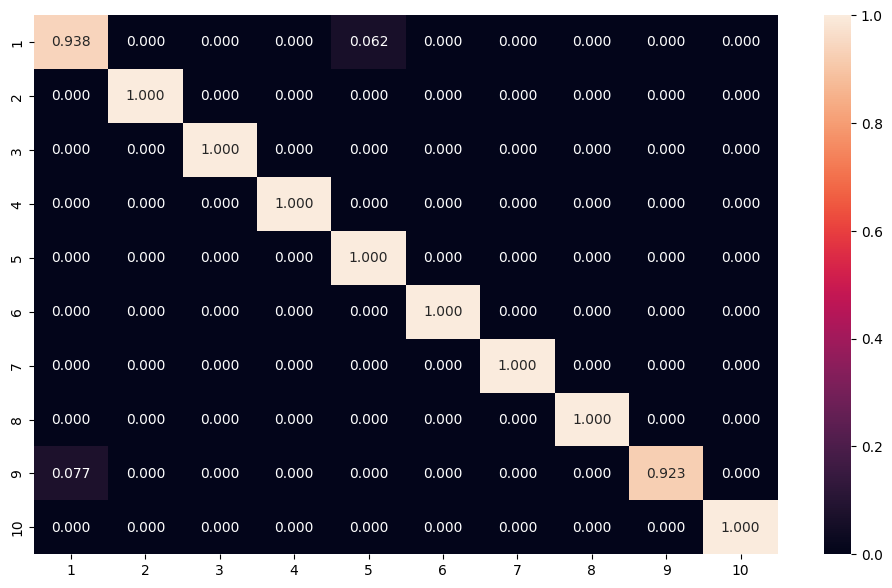

In [113]:
# Training loop
import gc
gc.collect()
torch.cuda.empty_cache()

#run = wandb.init(name='CNN', project='emg_benchmarking', entity='msoh')
#wandb.config.lr = learn

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

#wandb.watch(model)

for epoch in range(num_epochs):
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        train_loss += loss.item()

        train_acc += np.mean(np.argmax(output.cpu().detach().numpy(), 
                                       axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            output = model(X_batch)
            val_loss += criterion(output, Y_batch).item()

            val_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")

    '''
    wandb.log({
        "Epoch": epoch,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
    '''
#run.finish()

# Testing
pred = []
true = []

model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        output = model(X_batch)
        test_loss += criterion(output, Y_batch).item()

        test_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        output = np.argmax(output.cpu().detach().numpy(), axis=1)
        pred.extend(output)
        labels = np.argmax(Y_batch.cpu().detach().numpy(), axis=1)
        true.extend(labels)

test_loss /= len(test_loader)
test_acc /= len(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = np.arange(1, 11, 1),
                     columns = np.arange(1, 11, 1))
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt=".3f")
plt.savefig('output.png')